In [1]:
import os
import re
import pandas as pd
# from distributed import Client
# client = Client()
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def prepare_data(
    script_name: str = None,
    data_folder_script_relative_path: str = "data/",
    data_file_type: str = ".dat",
) -> dict:
    """

    Args:
        script_name (str): name of running script. Defaults to None.
        data_folder_script_relative_path (str): data folder path relative to running script. Defaults to "data/".
        data_file_type (str): type of data file. Defaults to ".dat".

    Returns:
        dict: keys are integers from 1 to 2921 equivalent to site observation location ID and values are arrays of shape (16, 327).
            rows 0-14; GHG concentrations of tracers emitted from regions 1-15; row 15 is GHC concentrations of synthetic observations
            columns 0-326; GHC concentrations every 6 hour from May 10 to July 31, 2010 
            timestamps can be constructed in case required like:
            observation_start = pd.to_datetime("2010-05-10 18:00:00")
            total_samples = 327
            time_interval = pd.Timedelta(6, "h")
            timestamps = pd.to_datetime(
                [observation_start + i * time_interval for i in range(total_samples)]
    """

    script_path = os.path.abspath(path=script_name)
    # get the parent directory of the script (i.e., the scripts folder)
    scripts_folder = os.path.dirname(script_path)
    # move one level up to the parent directory of the scripts folder
    parent_folder = os.path.dirname(scripts_folder)
    # specify the relative path from the scripts folder to the data folder
    relative_path = data_folder_script_relative_path
    # construct the absolute path to the data folder
    data_folder = os.path.join(parent_folder, relative_path)
    # get a list of all files and directories in the folder
    file_list = os.listdir(data_folder)

    data_dict = {}
    # iterate over the files and process/import the .dat files
    for file_name in file_list:
        if file_name.endswith(data_file_type):
            # get observation site location id
            obs_site_loc_id = [int(num) for num in re.findall(r"\d+", file_name)][0]
            file_path = os.path.join(data_folder, file_name)
            with open(file_path, "r") as file:
                contents = file.read()
                # split the long string into lines
                rows = contents.splitlines()
                # 16 rows expected; rows 1-15 for 15 regions and row 16 for synthetic observations
                rows = rows[:16]
                # determine the number of columns from the first row
                num_columns = len(rows[0].split())
                assert (
                    num_columns == 327
                ), f"327 concentration columns are expected while {num_columns} columns were detected!"
                try:
                    # Load the data as a 2D float array, selecting a subset of columns
                    data_dict[obs_site_loc_id] = np.loadtxt(
                        rows, usecols=range(num_columns), dtype=float
                    )
                except ValueError as e:
                    print(f"Error processing file {file_name}: {e}")
    assert (
        len(data_dict.keys()) == 2921
    ), f"2921 observation sites are expected while {len(data_dict.keys())} sites were detected!"
    return data_dict

In [50]:
def time_series_visualizer(data: dict = None, obs_site_id: int = None):
    obs_site_data = data[obs_site_id]
    pd.DataFrame(
        data=obs_site_data.T, index=[(6 + i * 6) / 24 for i in range(327)]
    ).plot(
        subplots=True,
        layout=(4, 4),
        figsize=(25, 15),
        xlabel="relative observation time, days",
        ylabel="GHG tracer concentration, ppt",
        sharex=False,
        title="GHG actual concentrations for regions 1-15 and synthetic (simulated) concentration for region 16",
    )
    plt.show()

In [4]:
data = prepare_data("inverse_methods_and_dual_objective_optimization.ipynb")

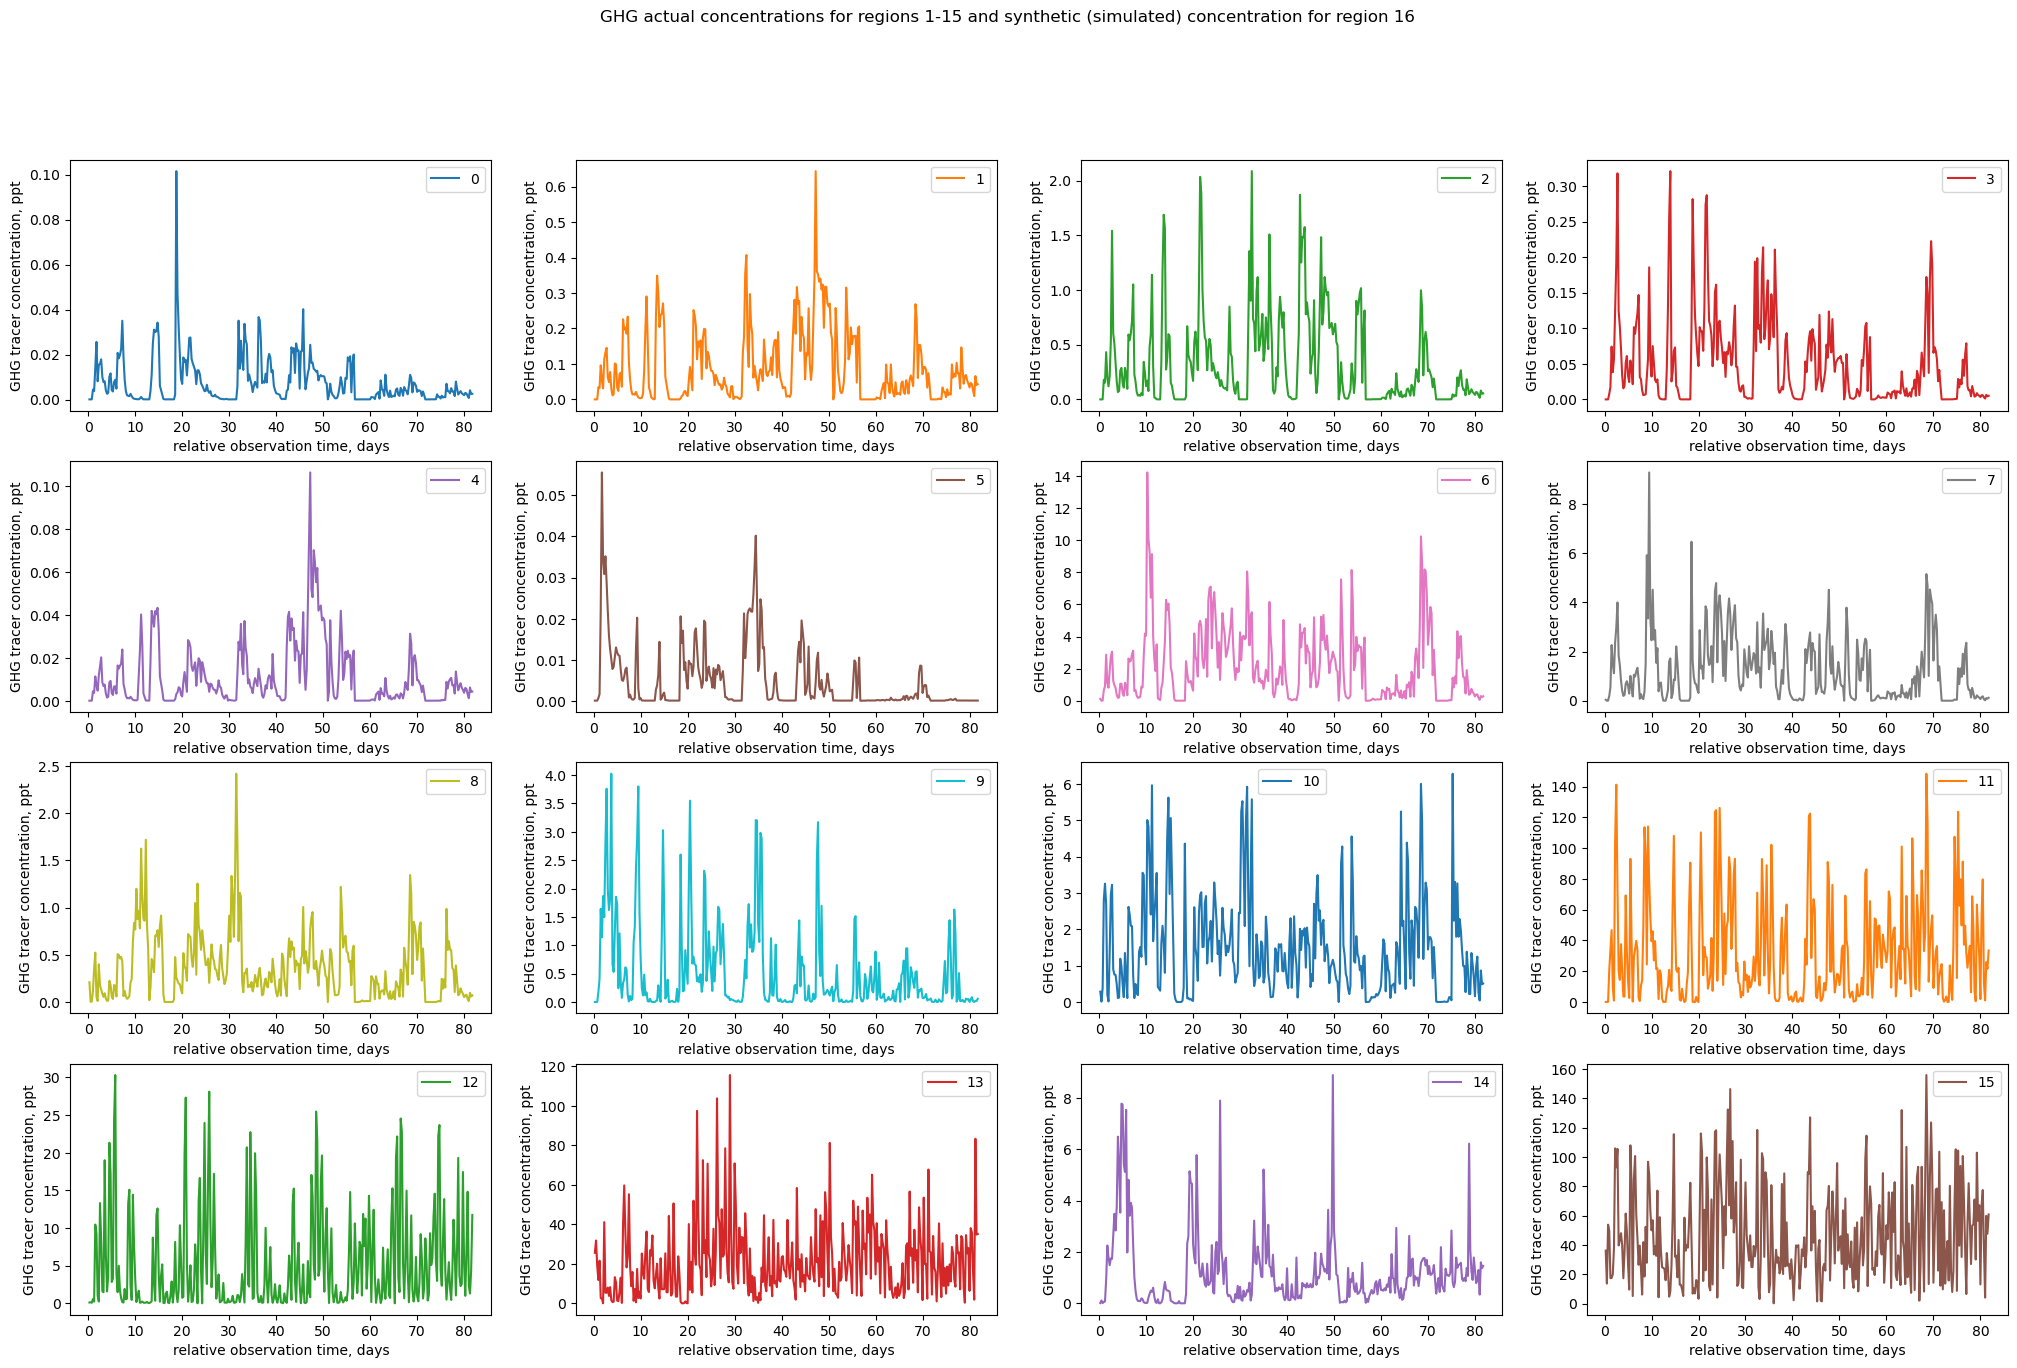

In [51]:
time_series_visualizer(data=data, obs_site_id=110)

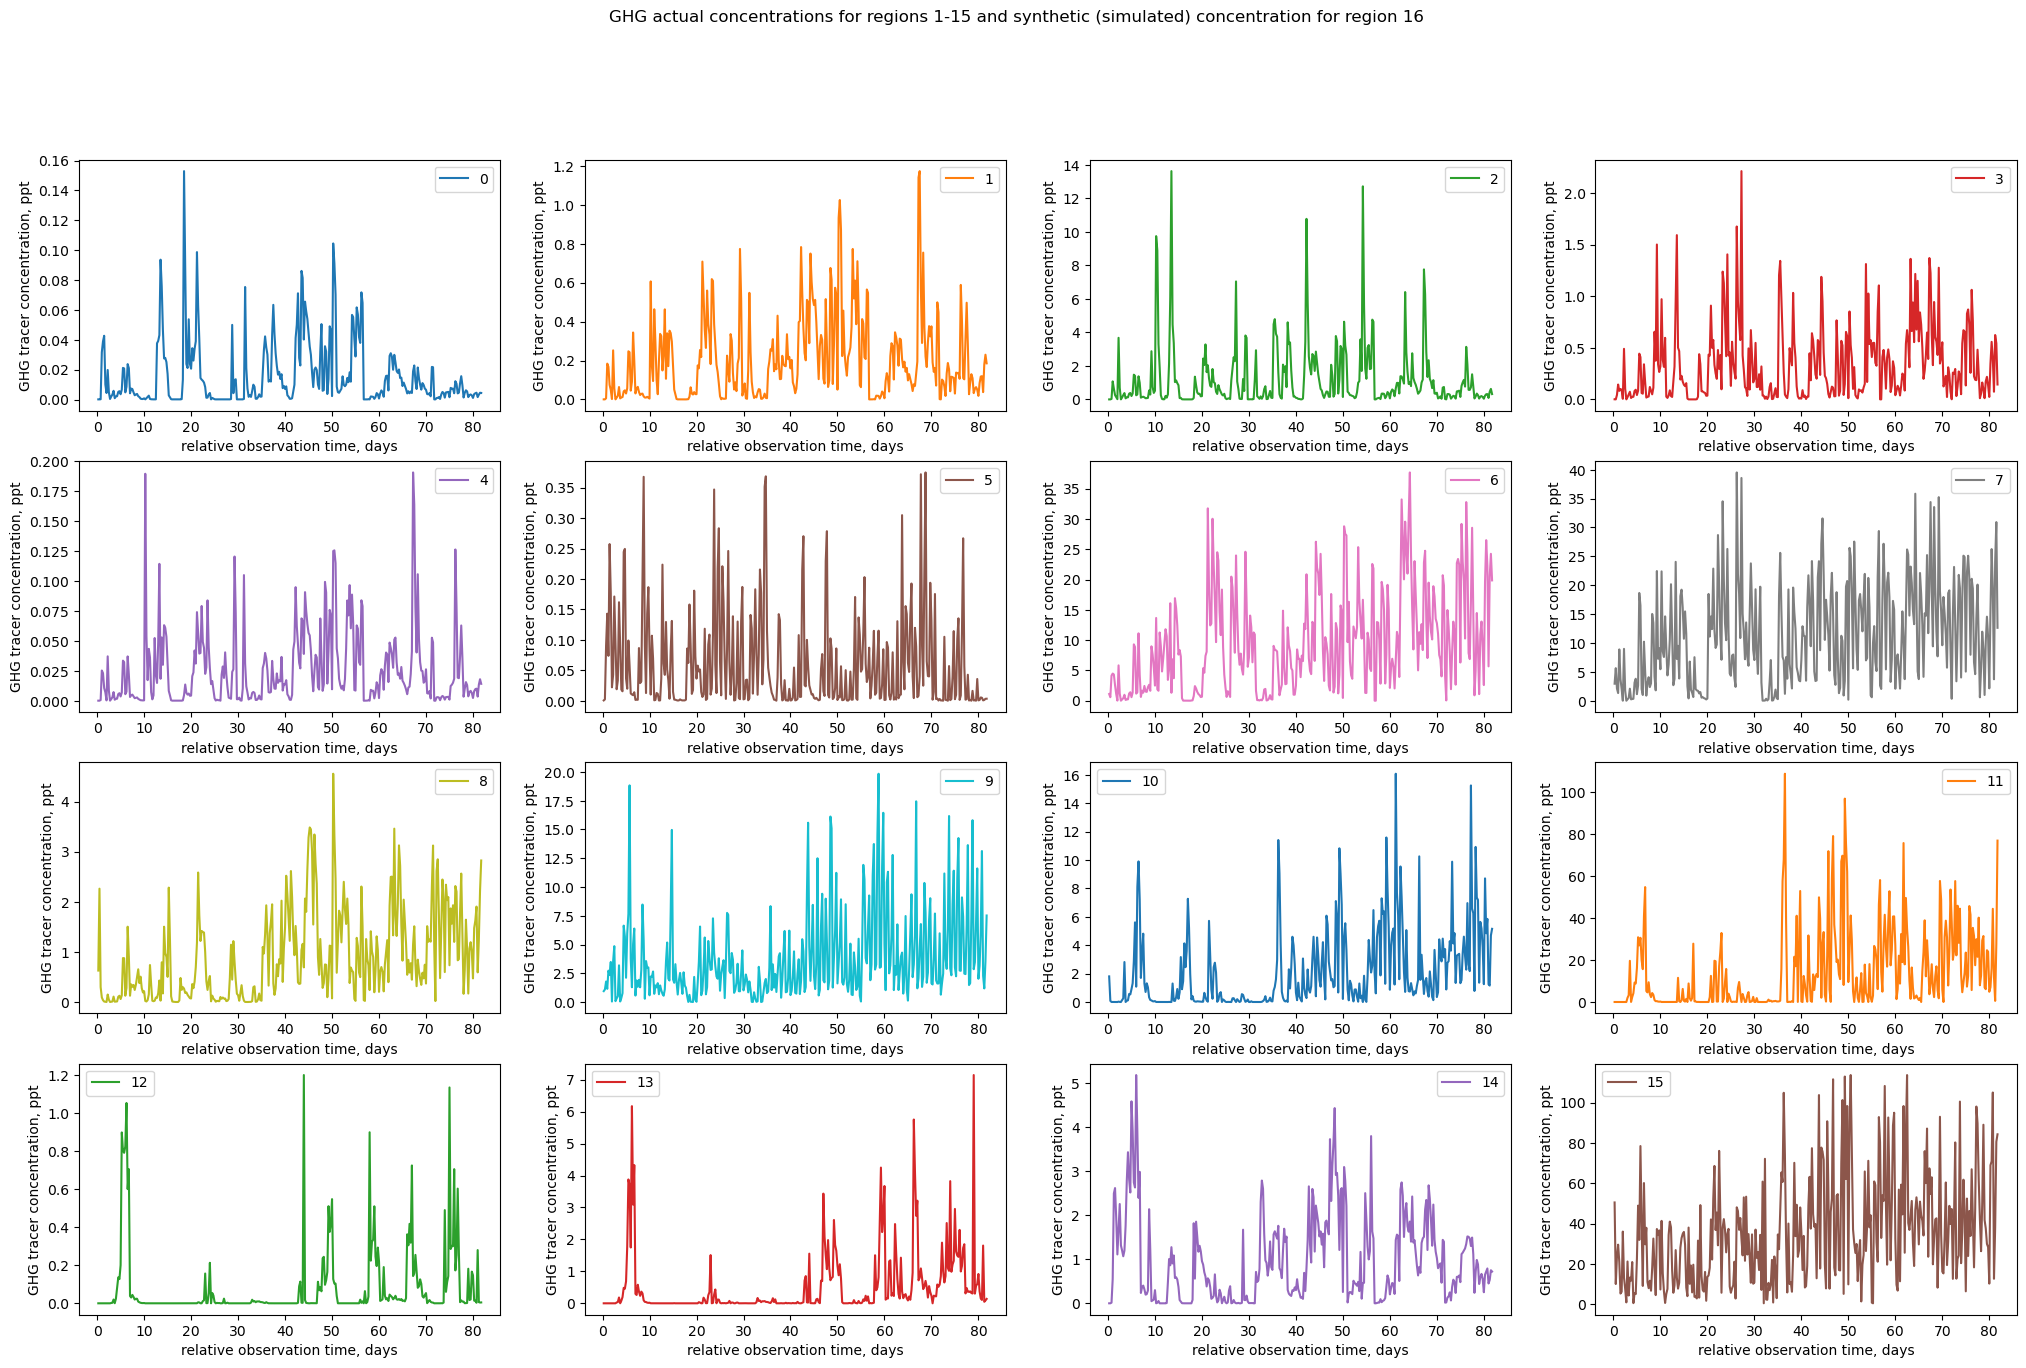

In [52]:
time_series_visualizer(data=data, obs_site_id=1000)